In [1]:
%pylab inline --no-import-all

# Our standard network analysis module. Please use as nx so I may read code more easily.
import networkx as nx
# Our standard ploting module. Again, please use as plt.
import matplotlib.pyplot as plt
# numpy can be more efficient at getting sum, max, min, etc. out of arrays and lists.
import numpy as np
# Can be used to make the printing of certain objects (especially dictionaries and tuples) easier for humans.
import pprint
# Just a lazy way of supressing warnings
# import warnings
# warnings.filterwarnings('ignore')
import pandas as pd

# from IPython.core.display import HTML

Populating the interactive namespace from numpy and matplotlib


First we load the airport network.

In [3]:
from load_data import load_data, weighted_network_creation
from utils import plt_directed

# Add external information
# Airport_Network = load_data()
Airport_Network = weighted_network_creation()

# Print out the summary information of the graphs
print('Airport_Network Informations Summary: \n')
print(nx.info(Airport_Network),'\n')

Airport_Network Informations Summary: 

Name: 
Type: DiGraph
Number of nodes: 3334
Number of edges: 37505
Average in degree:  11.2493
Average out degree:  11.2493 



In [4]:
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics.SIRModel as sir
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend 

no display found. Using non-interactive Agg backend


In [5]:
def init_sir_model(network, infected, beta=0.01, gamma=0.01):
    sir_model = sir.SIRModel(network)
    
    #initialize the parameters
    sir_cfg = mc.Configuration()
    sir_cfg.add_model_parameter('beta', beta)
    sir_cfg.add_model_parameter('gamma', gamma)
    
    sir_cfg.add_model_initial_configuration('Infected', infected)
    
    sir_model.set_initial_status(sir_cfg)
    
    return sir_model


In [6]:
def time_infected(iterations):
    """Given a simulation, return a dictionary with the number of steps
    since each node was infected.
    """
    res = {i: 0 for i in iterations[0]['status'].keys()}
    
    current_status = {}
    
    for it in iterations:
        current_status.update(it['status'])
        for k, v in current_status.items():
            if v != 0:
                res[k] += 1
    
    return res


def pair_elements(*args):
    output = []
    for node_id in args[0].keys():
        output.append(tuple(i[node_id] for i in args))
    return np.array(output)

In [7]:
# List of airports
london_airports = ['503', '502', '492', '174', '548', '507']

In [8]:
model = init_sir_model(Airport_Network, london_airports, beta=0.01, gamma=0.01)

In [9]:
model.reset()
iterations = model.iteration_bunch(500)
trends = model.build_trends(iterations)

Here, we try plotting graphs using the SIR Model, and take reasonable values of Gamma and Beta (0.01) to give us a more accurate representation of our case. Gamma represents how fast the disease spreads and Beta measures how deadly the disease is. So if Beta is very high, then everyone would die at the airport where the disease originates so we have to be careful with the number we choose.

In the SIR MODEL, S refers to susceptible. The susceptible are the ones that are not infected with the disease yet, but they are not immune to it either and there is a possibility to become infected with the disease in the future. The I refer to the people who are infected or were infected in the past. These are people that are infected with the disease and can transmit the disease to the susceptible. And, the R refers to the people who have recovered from the disease. These people are those who have recovered from the disease and are immune, so they can no longer be infected with the disease. 


/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


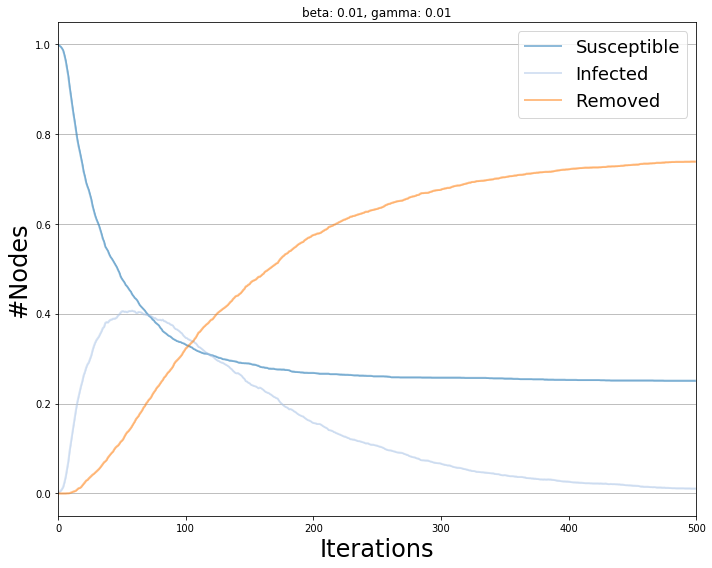

In [10]:
plt.figure(figsize=(10, 8))
viz = DiffusionTrend(model, trends)
viz.plot()

However, there are certain drawbacks to the SIR model. For instance, it does not take into account the people being born, and the people dying. That is the people who are new to the susceptible category and the ones who are removed from the susceptible, infected and recovered categories.


In [11]:
def plot_data(network, data, **kwargs):
    values = pair_elements(
        nx.get_node_attributes(network, "Latitude"),
        nx.get_node_attributes(network, "Longitude"),
#         model.status
#         time_infected(iterations)
        data
    )
    
    plt.scatter(values[:, 1], values[:, 0], c=values[:, 2], alpha=0.8, marker='.', **kwargs)
    plt.colorbar()

Here we have a map of the all the airports with their latitudes and longitudes, and plot the graph. This map represents the number of steps/iterations since the airport got infected, because once the airport is infected we consider it is infected forever. So the ones with ZERO (0 - at the bluer end of the spectrum) are not affected. 

Text(0.5, 1.0, 'Iterations infected')

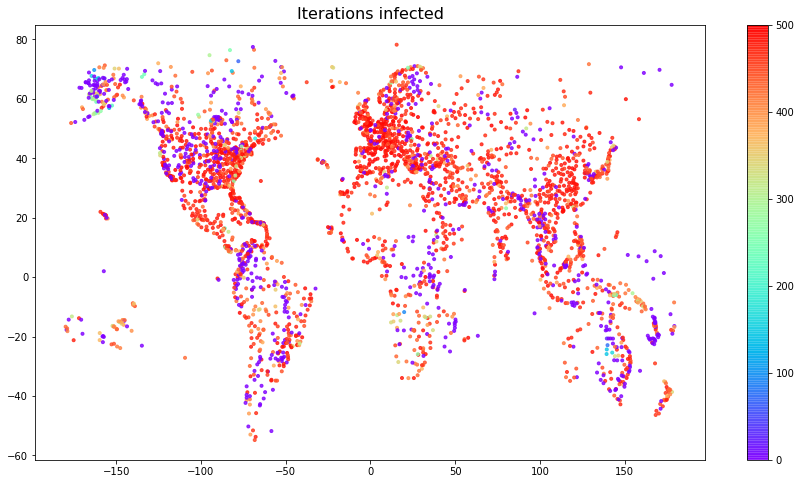

In [12]:
plt.figure(figsize=(15, 8))
plot_data(Airport_Network, time_infected(iterations), cmap='rainbow')
plt.title("Iterations infected", fontsize=16)

Run 5 iterations and check the number of airports infected.

In [13]:
num_warmup_iters = 5
model.reset()
iterations = model.iteration_bunch(num_warmup_iters)
trends = model.build_trends(iterations)

Here, we take 5 iterations, and see what airports get affectedd. So, this map represents the airports which since the airport got infected after 5 iterations. The ones with the red dots are the ones which got infected. The purple ones are the airports which did not get infected. Again, it is a spectrum from purple to red.

Text(0.5, 1.0, 'Infected airports after 5 iterations')

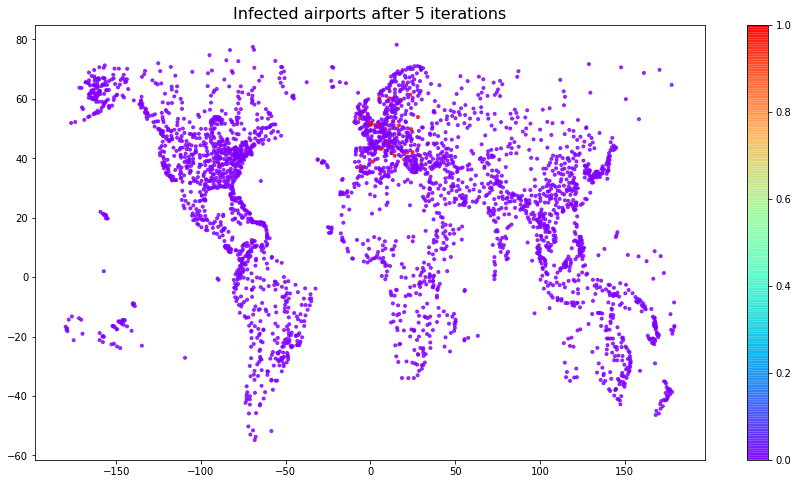

In [14]:
plt.figure(figsize=(15, 8))
plot_data(Airport_Network, {k: v>0 for k, v in time_infected(iterations).items()}, cmap='rainbow')
plt.title("Infected airports after 5 iterations", fontsize=16)

In [15]:
print("After {} iterations...".format(num_warmup_iters))
print("Airports infected: {}, airports removed: {}".format(iterations[-1]['node_count'][1], iterations[-1]['node_count'][2]))
warmup_status = model.status
airports_infected = [k for k, v in model.status.items() if v==1]

After 5 iterations...
Airports infected: 38, airports removed: 0


In [16]:
# Create a copy of the network
network_copy1 = Airport_Network.copy()
# Remove the links from the infected airports to check if this can stop the infection
for airport in airports_infected:
    edges = list(network_copy1.edges(airport))
    network_copy1.remove_edges_from(edges)

In [17]:
model_1 = init_sir_model(network_copy1, airports_infected, 0.01, 0.01)
model_1.reset()
iterations = model_1.iteration_bunch(500)
trends = model_1.build_trends(iterations)

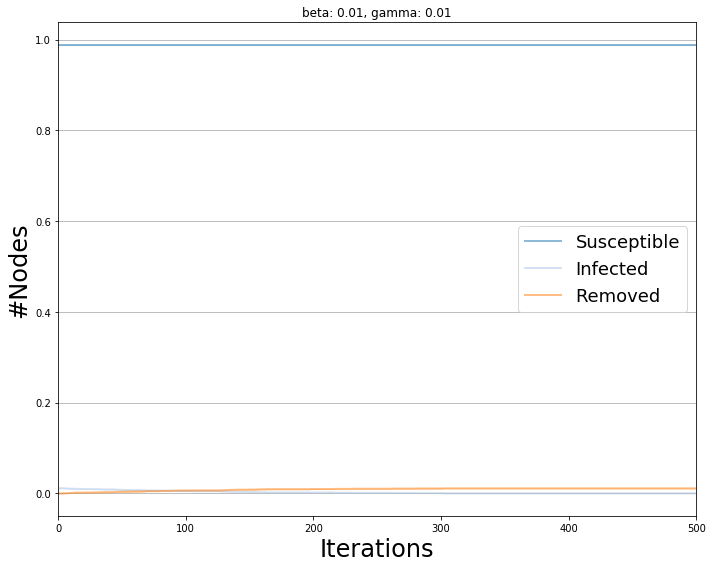

In [18]:
plt.figure(figsize=(10, 8))
viz = DiffusionTrend(model_1, trends)
viz.plot()

The expansion of the infection is stopped.

Now we analyze the evolution of the infection when we remove a subset of the edges of the infected airports. In particular, edges to nodes with high out degree are removed first.

In [19]:
def stop_infection(network, infected_airports, percentile):
    """
    Returns a copy of the input network such that a given percentage of airports that
    are neighbors of the infected_airports are closed, i.e., all the edges from the
    infected airports to them are removed.
    
    The percentile indicates that all airports in the given percentile of out-degrees
    are closed. If 100, all airports that are neighbors to infected_airports are closed.
    If 50, only half of the airports with the largest out-degree that are neighbors to
    infected_airports are closed.
    """
    
    # Compute the maximum out-degree of the neighbors of
    neighbors = set()
    for airport in infected_airports:
        for edge in network.edges(airport):
            neighbors.add(edge[1])

    # Get the neighbors and their degrees
    neighbors = list(network.out_degree(neighbors))
    # Sort the neighbors by degree
    sorted_neighbors = sorted(neighbors, key=lambda x: x[1])[::-1]
    num_blocked = int(len(neighbors) * percentile / 100.0)
    closed_airports = [i for i, _ in sorted_neighbors[:num_blocked]]
    
    print("{}/{} airports closed".format(num_blocked, len(neighbors)))
    
    # Create a copy of the network
    network = network.copy()
    for airport1 in infected_airports:
        for airport2 in closed_airports:
            # Airport2 is closed. Remove any link between airport1 and airport2.
            if network.has_edge(airport1, airport2):
                network.remove_edge(airport1, airport2)
    
    return network


In the next few steps, we model one disease that can die (not always) in the first step/city. After this step we implement, two techniques: 1) we let the disease spread for 10 iterations & cut all the edges between the community & rest of the world. This will prevent spread of infection to the rest of the world. 2) we do not cut edges of community but cut the edges between infected nodes and their adjacent ones with high degrees.


In [20]:
simulations = {}
# Run several simulations with different percentages of closed airports.
percentiles = np.arange(80, 101)
for p in percentiles:
    for iteration in range(0, 10):
        network = stop_infection(Airport_Network, airports_infected, p)
        model = init_sir_model(network, airports_infected, 0.01, 0.01)
        model.reset()
        iterations = model.iteration_bunch(800)
        trends = model.build_trends(iterations)
    
        simulations[(p, iteration)] = (model, iterations, trends)


503/629 airports closed
503/629 airports closed
503/629 airports closed
503/629 airports closed
503/629 airports closed
503/629 airports closed
503/629 airports closed
503/629 airports closed
503/629 airports closed
503/629 airports closed
509/629 airports closed
509/629 airports closed
509/629 airports closed
509/629 airports closed
509/629 airports closed
509/629 airports closed
509/629 airports closed
509/629 airports closed
509/629 airports closed
509/629 airports closed
515/629 airports closed
515/629 airports closed
515/629 airports closed
515/629 airports closed
515/629 airports closed
515/629 airports closed
515/629 airports closed
515/629 airports closed
515/629 airports closed
515/629 airports closed
522/629 airports closed
522/629 airports closed
522/629 airports closed
522/629 airports closed
522/629 airports closed
522/629 airports closed
522/629 airports closed
522/629 airports closed
522/629 airports closed
522/629 airports closed
528/629 airports closed
528/629 airports

Here, we have 9 graphs per iteration, so in total, we get 9x10 = 90 curves for all the iterations. taking different percentages of neighbors which get affected due to the spread of the disease.

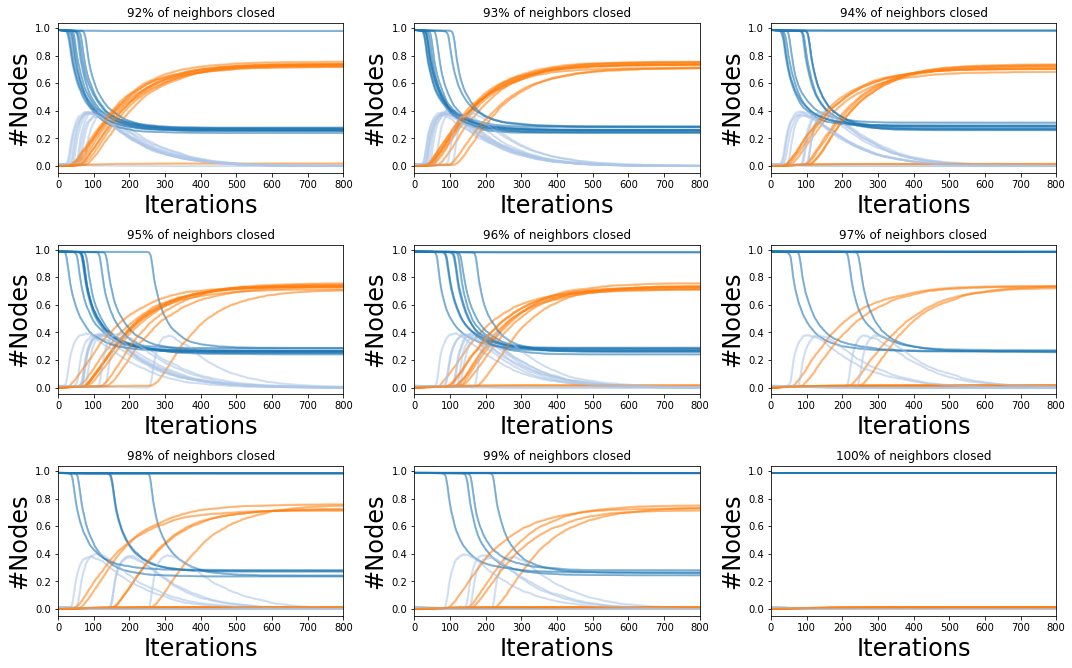

In [24]:
plt.figure(figsize=(15, 12))

for i, p in enumerate(range(92, 101)):
    plt.subplot(3, 3, i+1)
    for it in range(10):
        model, iterations, trends = simulations[(p,it)]
        viz = DiffusionTrend(model, trends,)
        viz.plot()
    plt.title("{}% of neighbors closed".format(p))
    
    plt.gca().get_legend().remove()

Here we plot an SIR graph of the airports after 800 iterations. We have the airports in consideration on one axis, and the percentage of its neighbors that get closed, and observe how the susceptible and removed remain constant throughout, and the removed decreases sharply, and susceptible increases sharply. 

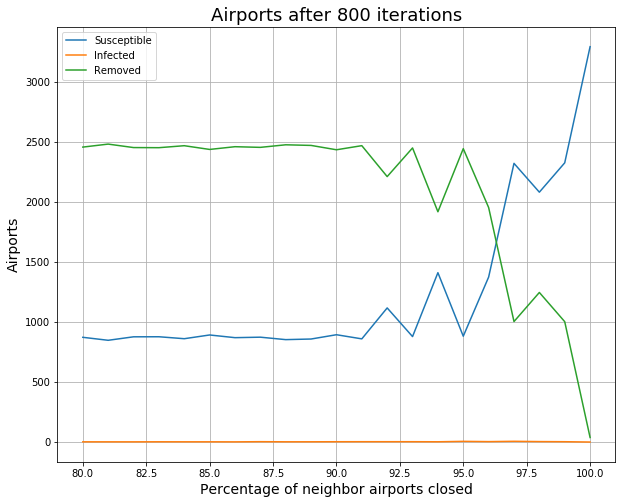

In [22]:
x = percentiles
susceptible = [np.mean([simulations[(p,iterations)][1][-1]['node_count'][0] for iterations in range(10)]) for p in x]
infected = [np.mean([simulations[(p,iterations)][1][-1]['node_count'][1] for iterations in range(10)]) for p in x]
removed = [np.mean([simulations[(p,iterations)][1][-1]['node_count'][2] for iterations in range(10)]) for p in x]

plt.figure(figsize=(10, 8))
plt.plot(x, susceptible, label="Susceptible")
plt.plot(x, infected, label="Infected")
plt.plot(x, removed, label="Removed")
plt.legend()
plt.title("Airports after 800 iterations", fontsize=18)
plt.xlabel("Percentage of neighbor airports closed", fontsize=14)
plt.ylabel("Airports", fontsize=14)
plt.grid()